Checking and installing required packages...

                    FAKE NEWS IMAGE DETECTION
               COMPREHENSIVE MODEL TESTING SUITE

STARTING COMPREHENSIVE MODEL TESTING

[TEST CASE 1] Individual Models on Full Data
--------------------------------------------------------------------------------
Found 2794 real news images
Found 9140 fake news images
Found 9547 images belonging to 2 classes.
Found 2387 images belonging to 2 classes.

[1a] Testing ResNet50...

Training: ResNet50 (Full Data)
Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1160s 4s/step - accuracy: 0.7604 - auc: 0.6781 - loss: 0.5199 - precision: 0.3796 - recall: 0.0367 - val_accuracy: 0.7658 - val_auc: 0.5000 - val_loss: 8.9686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1157s 4s/step - accuracy: 0.7905 - auc: 0.7650 - loss: 0.4644 - precision: 0.6233 - recall: 0.2658 - val_accuracy: 0.4843 - val_auc: 0.7343 - val_loss: 0.6863 - val_precision: 0.30

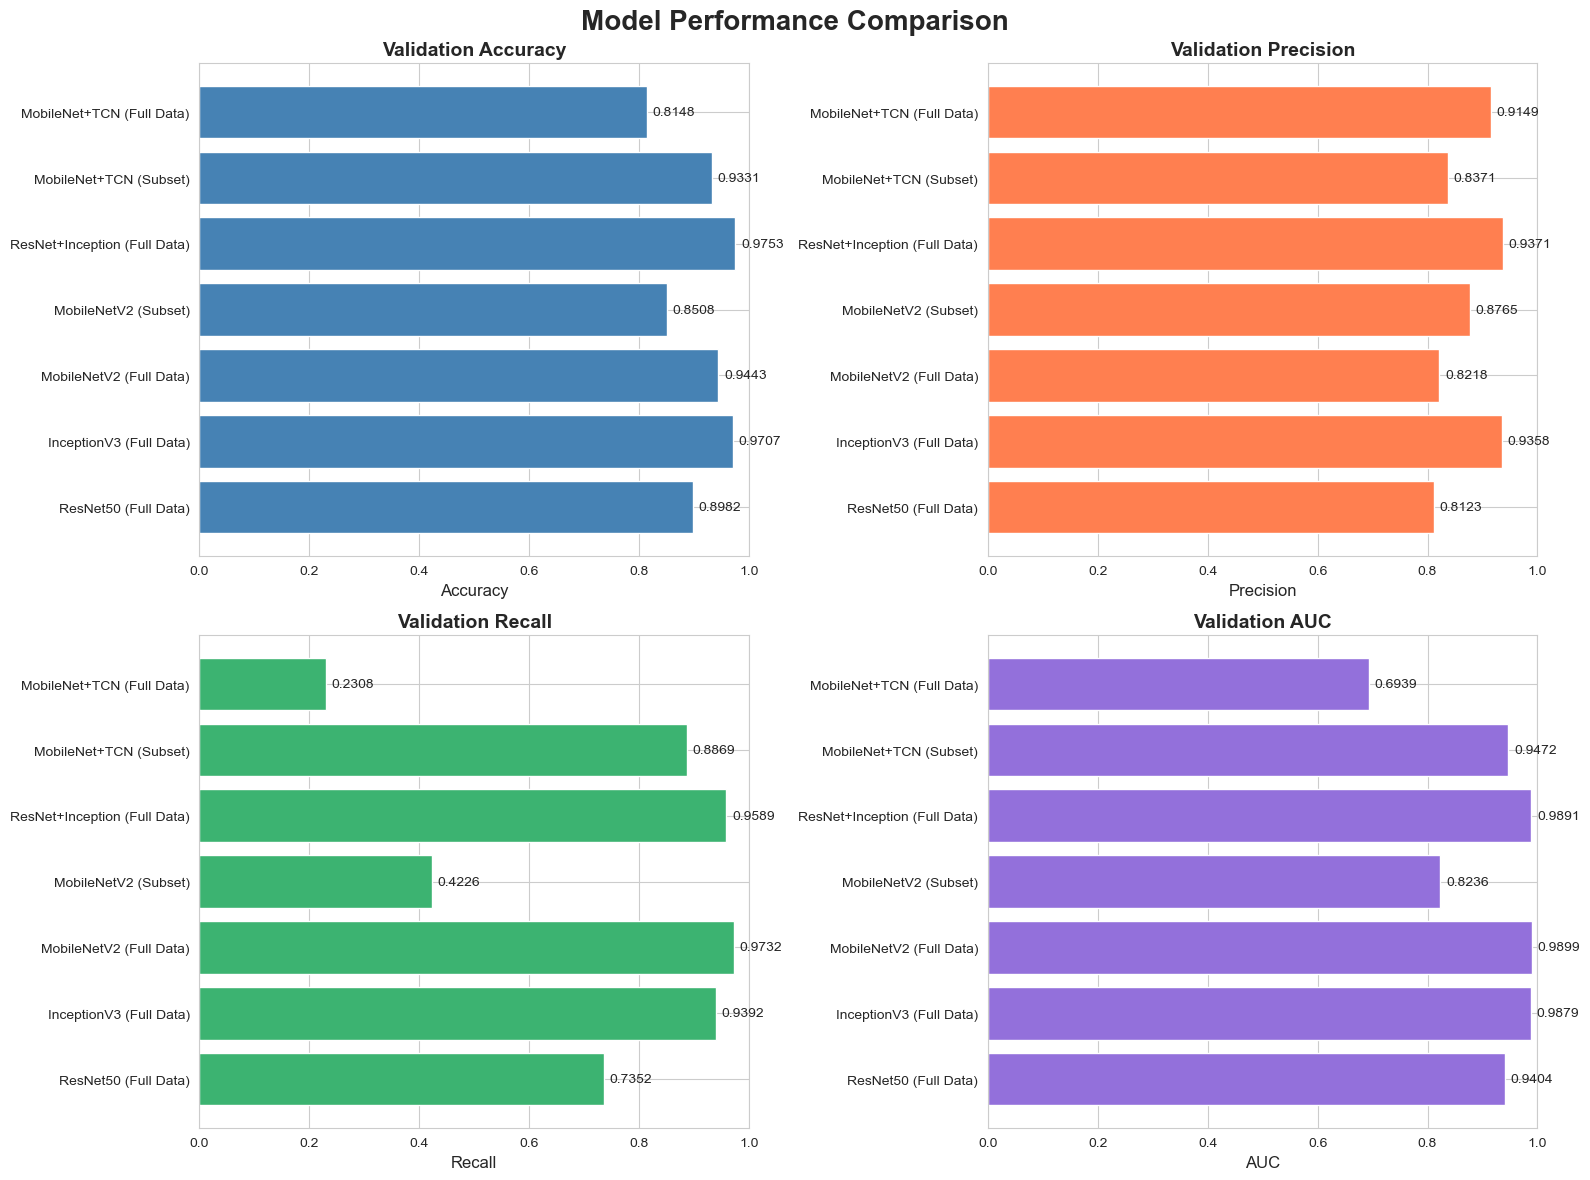

✓ Saved: overall_metrics_comparison.png


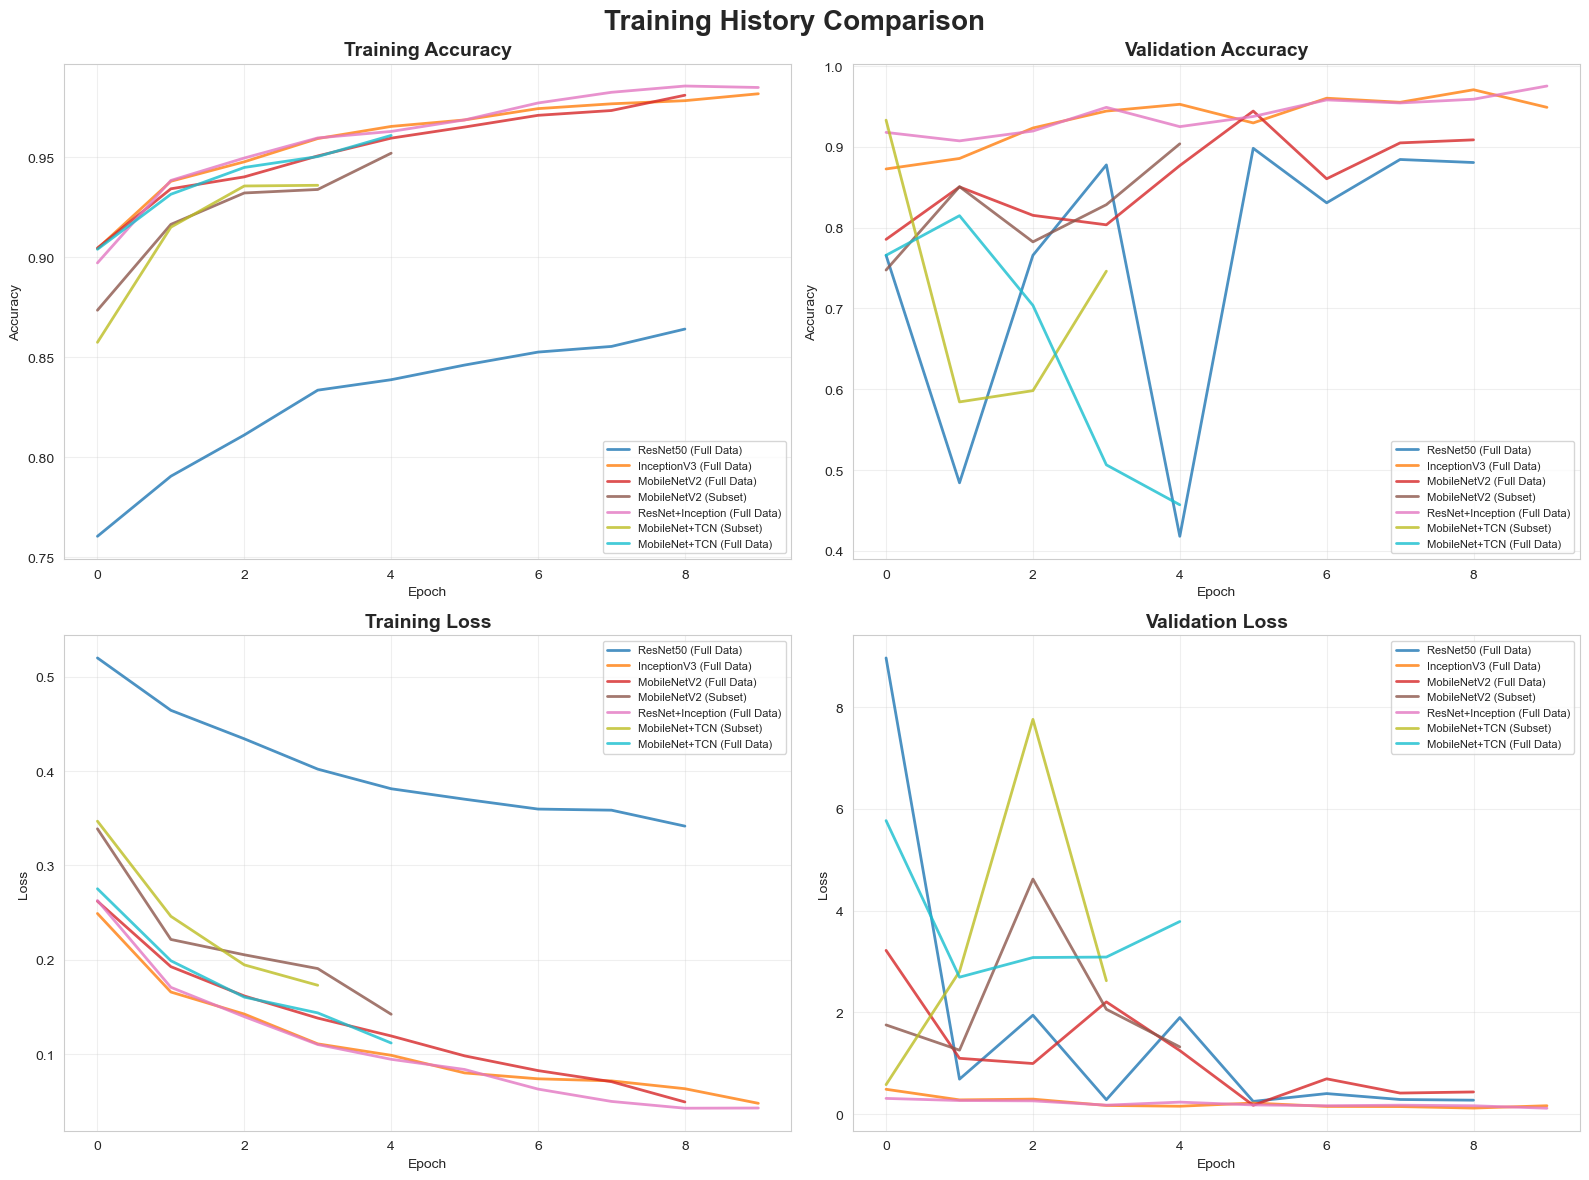

✓ Saved: training_history.png


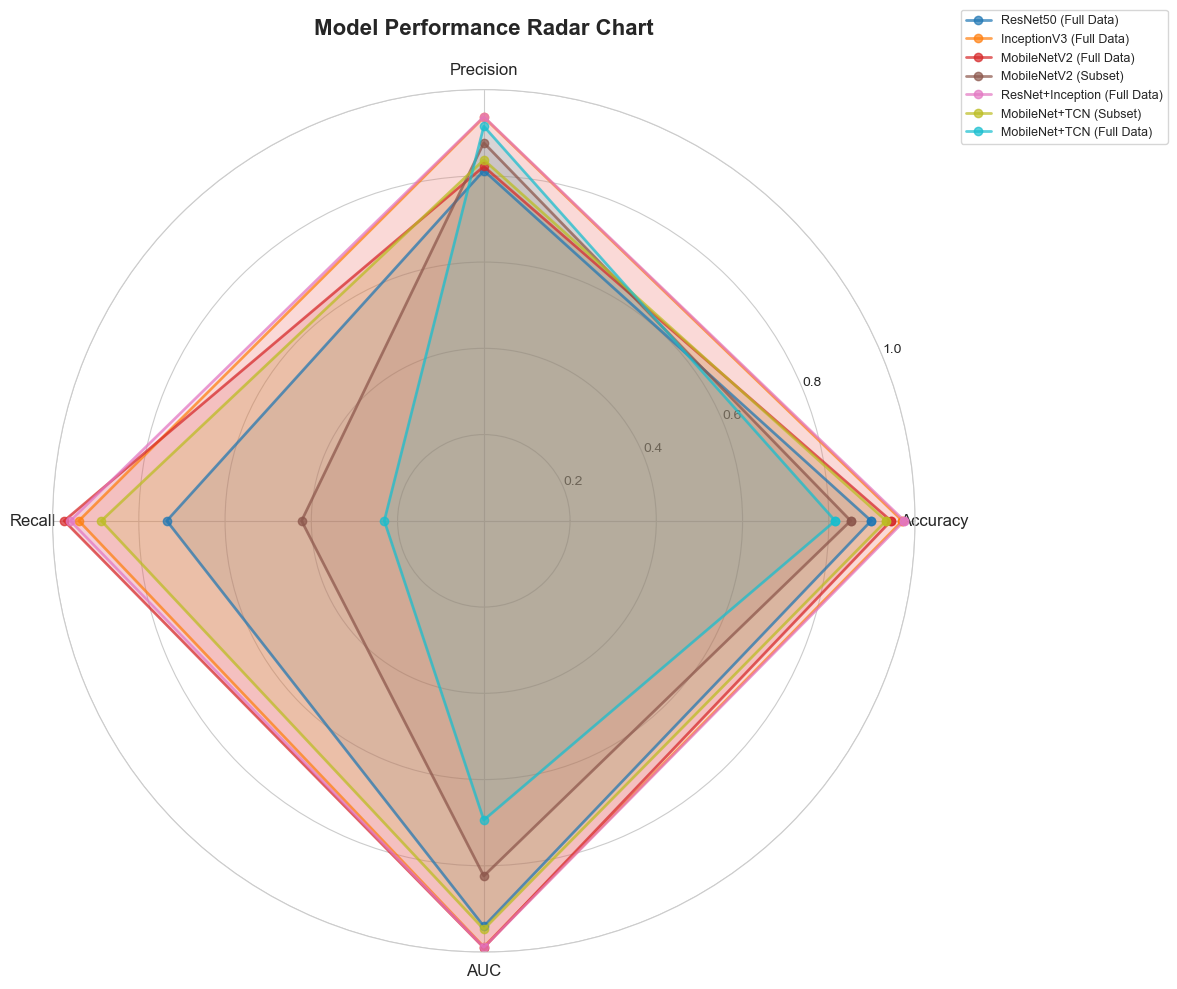

✓ Saved: performance_radar.png


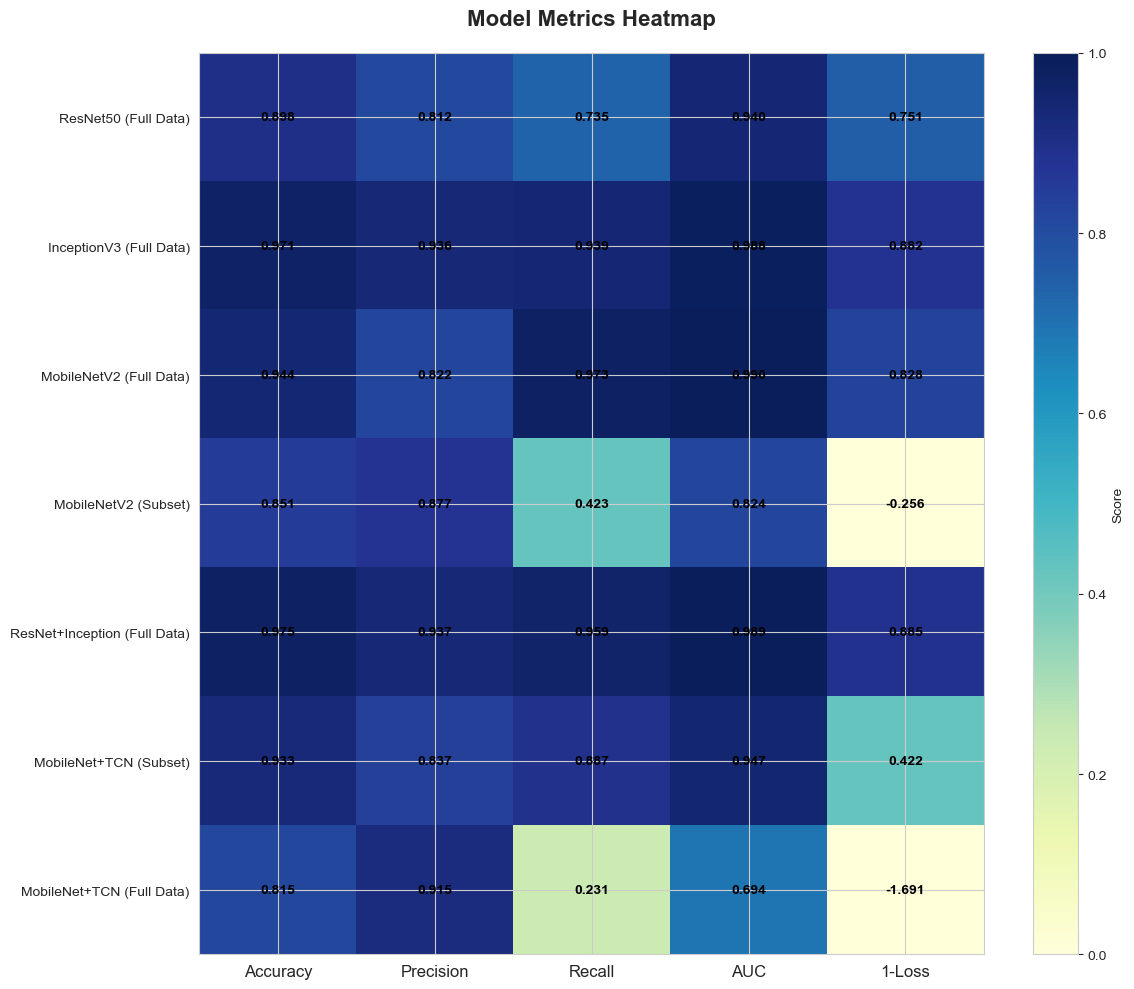

✓ Saved: metrics_heatmap.png


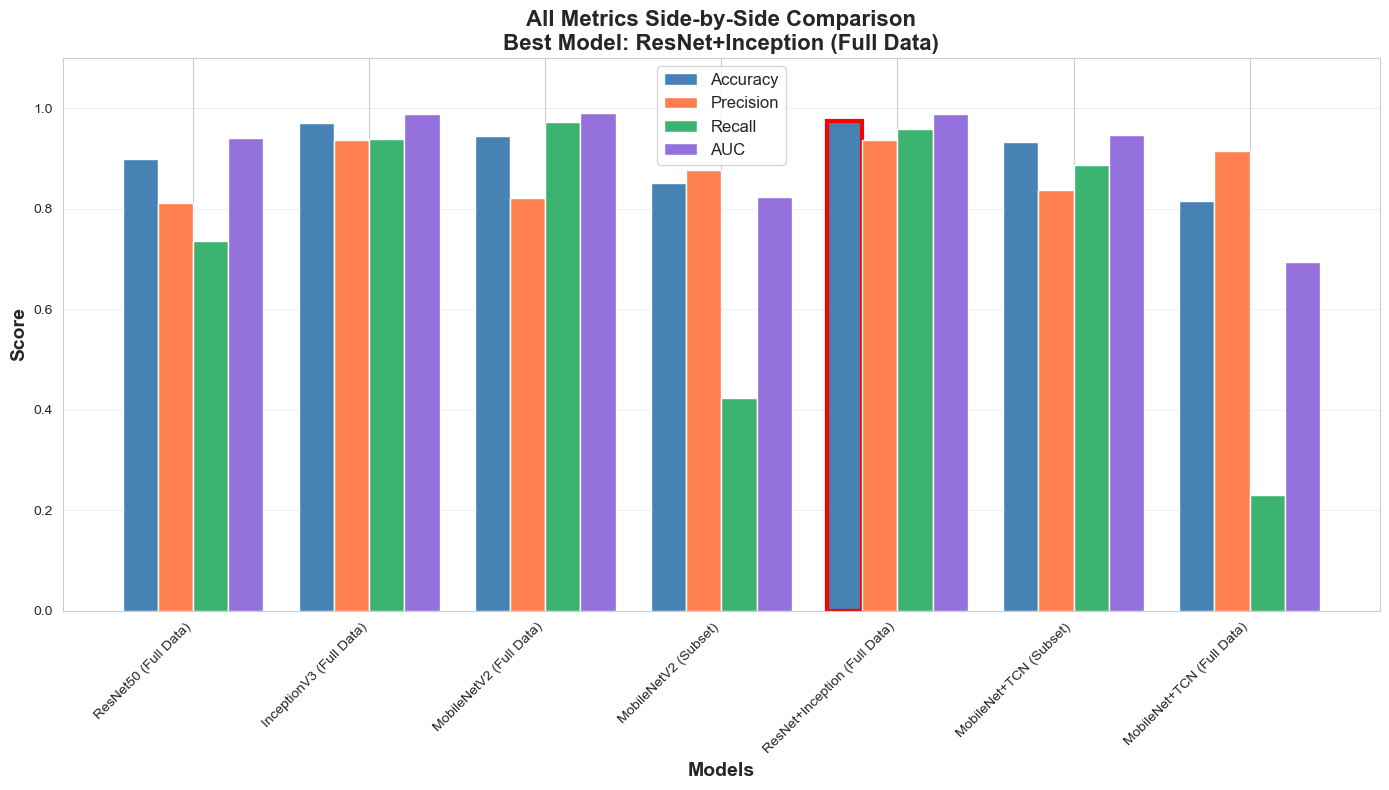

✓ Saved: side_by_side_comparison.png


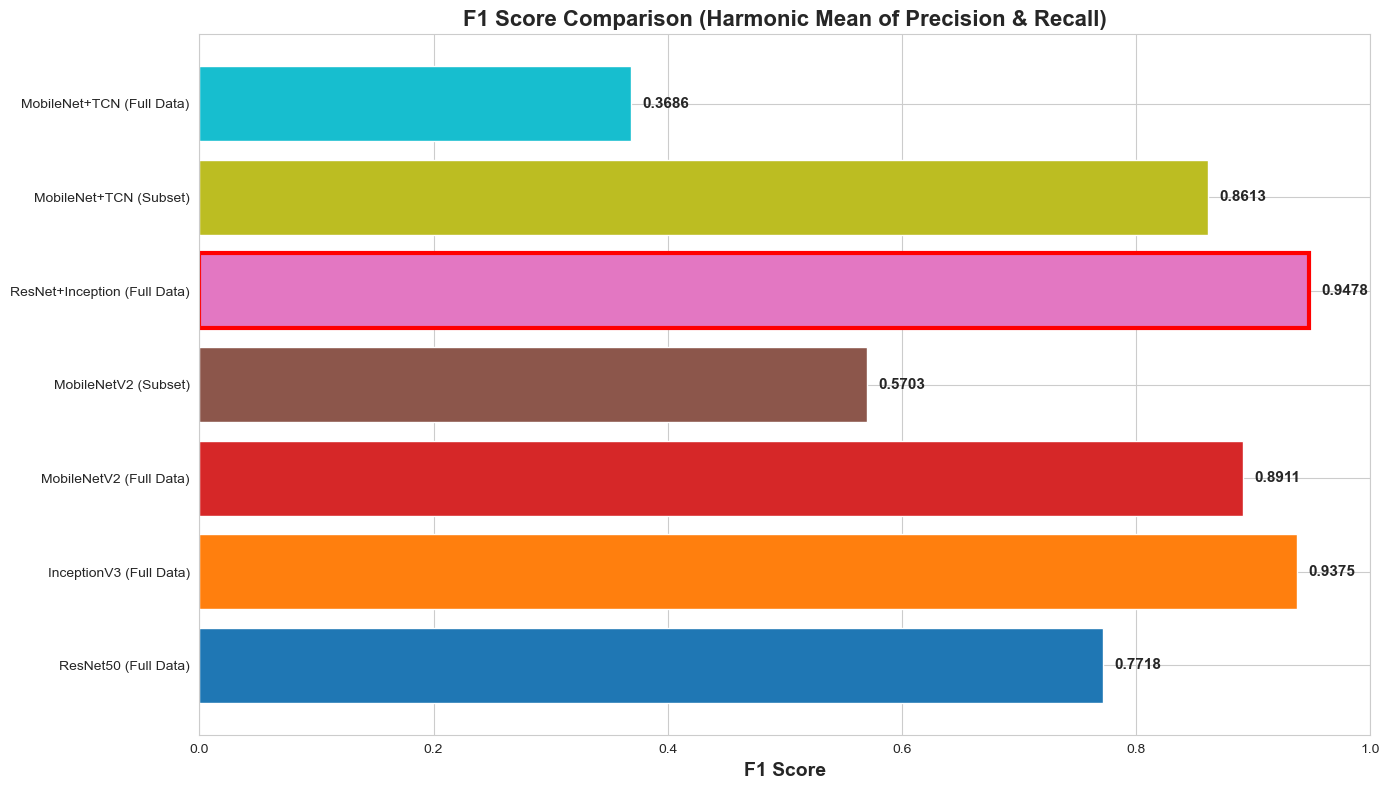

✓ Saved: f1_score_comparison.png


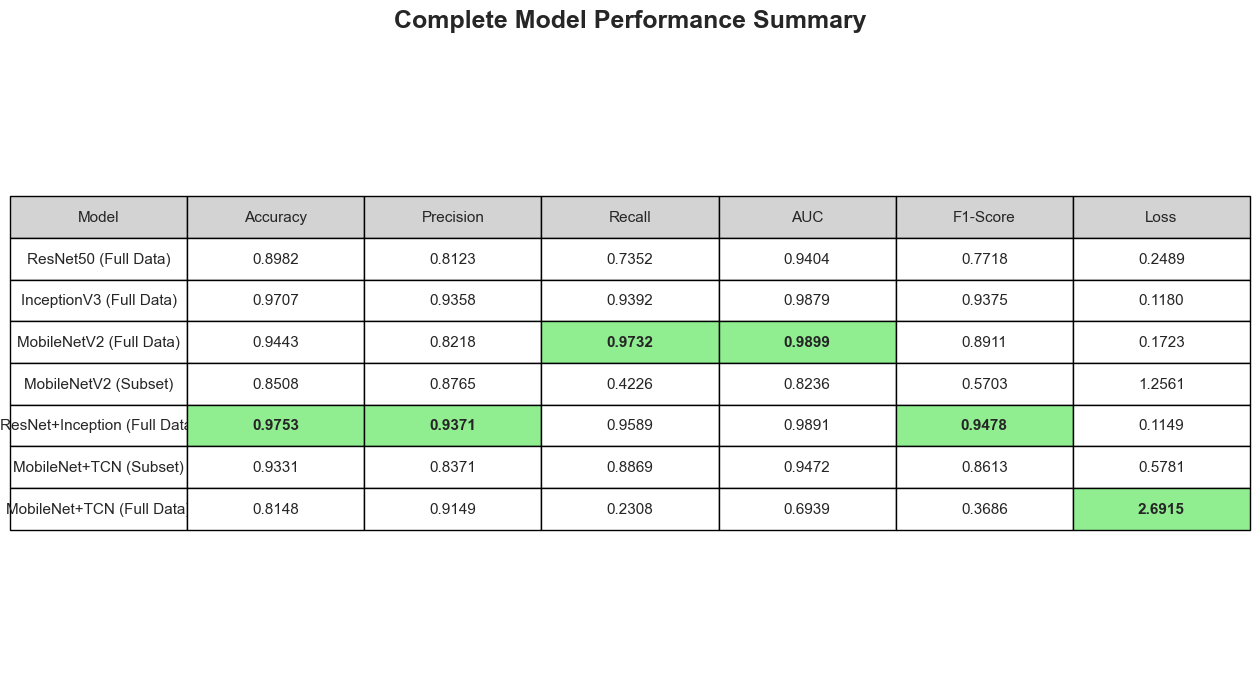

✓ Saved: summary_table.png
✓ Saved: model_comparison_summary.csv


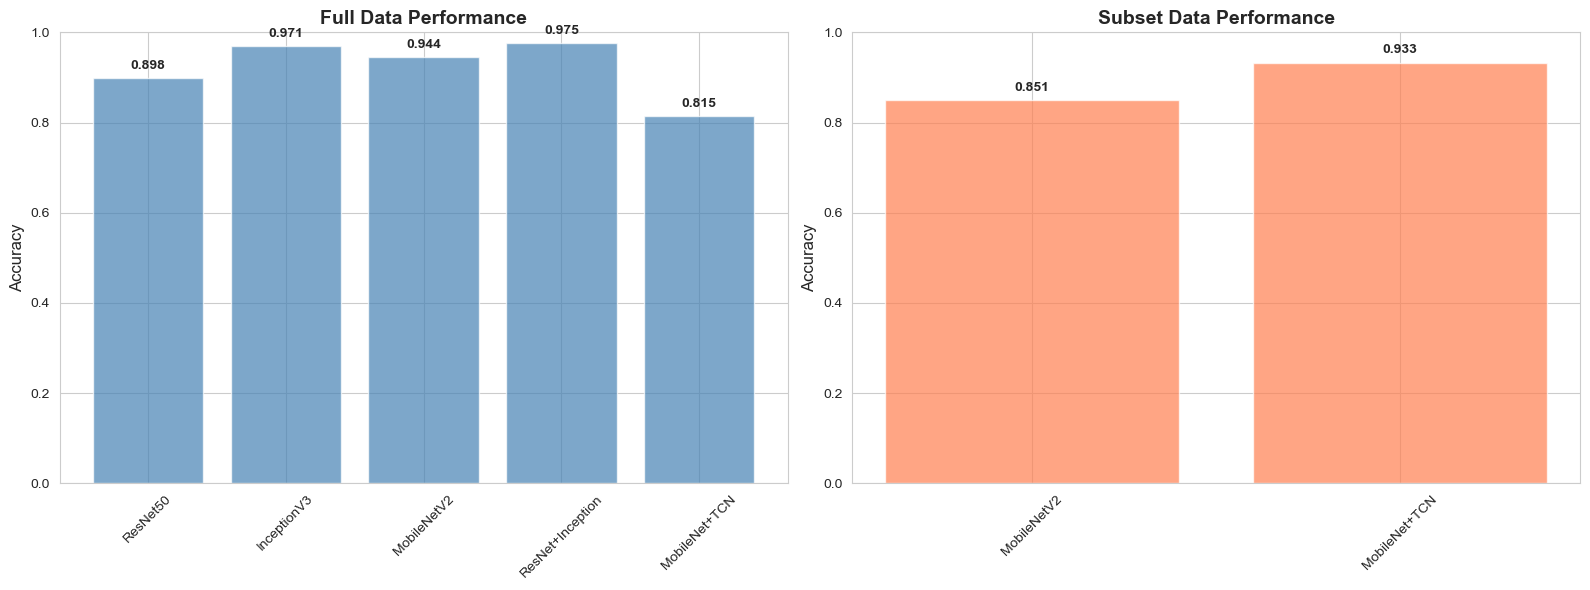

✓ Saved: full_vs_subset_comparison.png


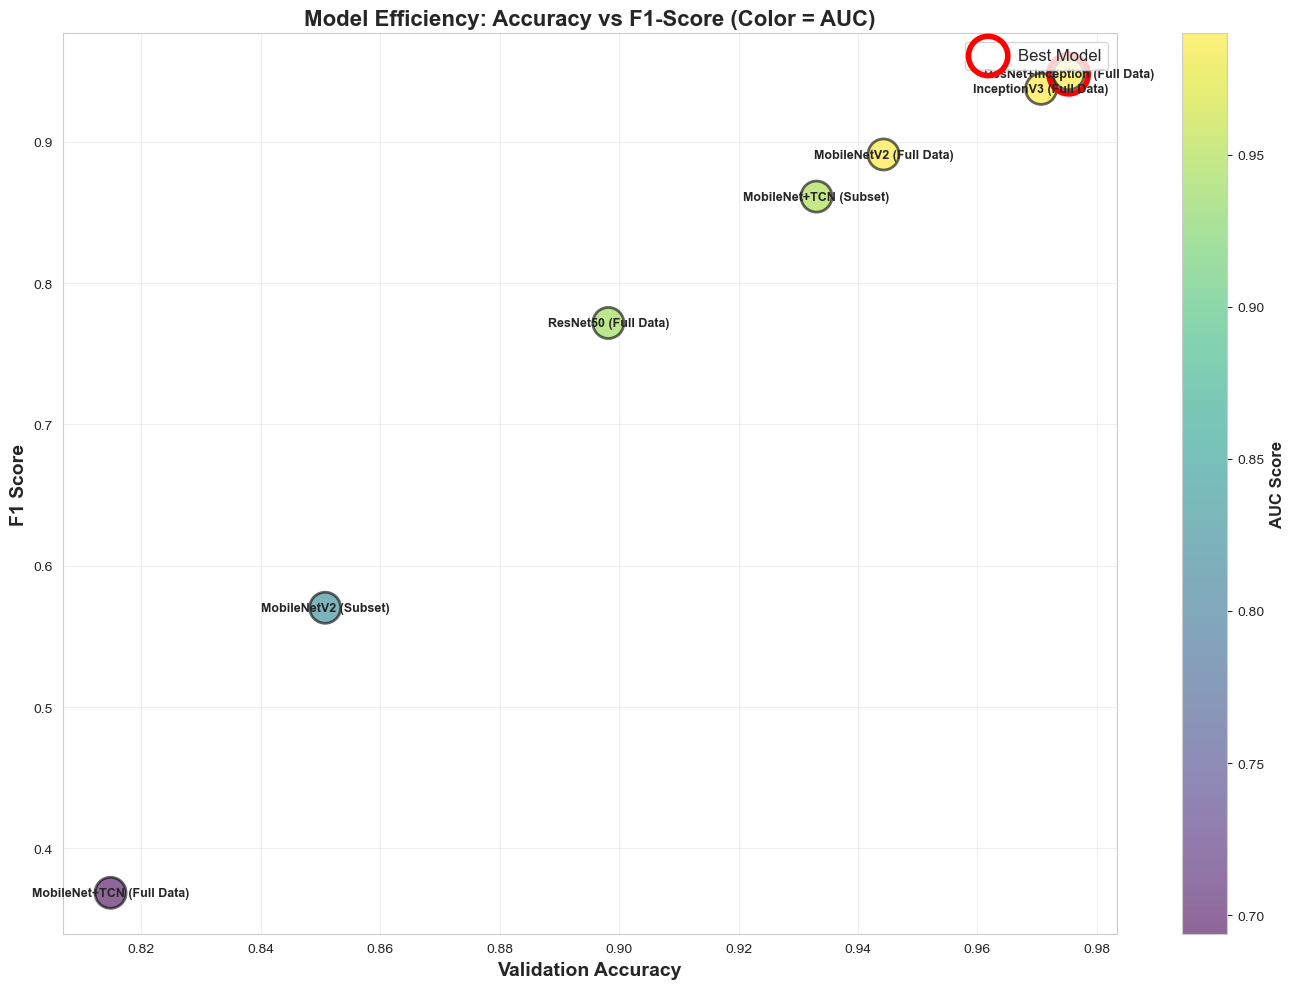

✓ Saved: efficiency_analysis.png

ALL VISUALIZATIONS COMPLETED!

Best Model: ResNet+Inception (Full Data)
Best Accuracy: 0.9753
Best F1-Score: 0.9478

All results saved in 'results/' directory

✓ Results saved to results/results.json

TESTING COMPLETE!

Generated Files:
  1. overall_metrics_comparison.png
  2. training_history.png
  3. performance_radar.png
  4. metrics_heatmap.png
  5. side_by_side_comparison.png
  6. f1_score_comparison.png
  7. summary_table.png
  8. full_vs_subset_comparison.png
  9. efficiency_analysis.png
  10. model_comparison_summary.csv
  11. results.json

FINAL SUMMARY

ResNet50 (Full Data):
  Accuracy:  0.8982
  Precision: 0.8123
  Recall:    0.7352
  AUC:       0.9404
  Loss:      0.2489

InceptionV3 (Full Data):
  Accuracy:  0.9707
  Precision: 0.9358
  Recall:    0.9392
  AUC:       0.9879
  Loss:      0.1180

MobileNetV2 (Full Data):
  Accuracy:  0.9443
  Precision: 0.8218
  Recall:    0.9732
  AUC:       0.9899
  Loss:      0.1723

MobileNetV2 (Subset):

In [1]:
"""
Comprehensive Fake News Image Detection Testing Suite
Tests multiple CNN architectures and their combinations with TCN
"""

import subprocess
import sys
import os

# Self-healing: Install required libraries
def install_and_import(package, import_name=None):
    """Install package if not found and import it"""
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
    finally:
        globals()[import_name] = __import__(import_name)

# Install all required packages
print("Checking and installing required packages...")
install_and_import("tensorflow")
install_and_import("numpy")
install_and_import("matplotlib")
install_and_import("seaborn")
install_and_import("pandas")
install_and_import("scikit-learn", "sklearn")
install_and_import("Pillow", "PIL")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import shutil
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Data paths
REAL_NEWS_PATH = r"C:\Users\dibya\OneDrive\Desktop\miniproj\realimagenews"
FAKE_NEWS_PATHS = [
    r"C:\Users\dibya\OneDrive\Desktop\miniproj\fakeddit_subset\fakeddit_subset\image_folder",
    r"C:\Users\dibya\OneDrive\Desktop\miniproj\snopes_medical\outputs\images"
]

# Results storage
results_dict = {}

def prepare_data_structure(use_full_data=True, subset_ratio=0.3):
    """Organize data into train/validation directories"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_dir = f"fake_news_dataset_{'full' if use_full_data else 'subset'}_{timestamp}"
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "validation")
    
    # Create directory structure
    for directory in [train_dir, val_dir]:
        os.makedirs(os.path.join(directory, "real"), exist_ok=True)
        os.makedirs(os.path.join(directory, "fake"), exist_ok=True)
    
    # Collect real images
    real_images = []
    if os.path.exists(REAL_NEWS_PATH):
        for ext in ['jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG']:
            real_images.extend(list(Path(REAL_NEWS_PATH).rglob(f"*.{ext}")))
    
    print(f"Found {len(real_images)} real news images")
    
    if len(real_images) == 0:
        raise ValueError(f"No images found in {REAL_NEWS_PATH}")
    
    # Collect fake images
    fake_images = []
    for fake_path in FAKE_NEWS_PATHS:
        if os.path.exists(fake_path):
            for ext in ['jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG']:
                fake_images.extend(list(Path(fake_path).rglob(f"*.{ext}")))
    
    print(f"Found {len(fake_images)} fake news images")
    
    if len(fake_images) == 0:
        raise ValueError(f"No images found in fake news paths")
    
    # Subset data if needed
    if not use_full_data:
        np.random.shuffle(real_images)
        np.random.shuffle(fake_images)
        real_images = real_images[:int(len(real_images) * subset_ratio)]
        fake_images = fake_images[:int(len(fake_images) * subset_ratio)]
        print(f"Using subset: {len(real_images)} real, {len(fake_images)} fake")
    
    # Split and copy real images (80-20)
    np.random.shuffle(real_images)
    split_idx = int(0.8 * len(real_images))
    
    for i, img_path in enumerate(real_images):
        try:
            dest_dir = train_dir if i < split_idx else val_dir
            dest_path = os.path.join(dest_dir, "real", f"{i}_{img_path.name}")
            shutil.copy2(img_path, dest_path)
        except Exception as e:
            print(f"Error copying {img_path}: {e}")
            continue
    
    # Split and copy fake images (80-20)
    np.random.shuffle(fake_images)
    split_idx = int(0.8 * len(fake_images))
    
    for i, img_path in enumerate(fake_images):
        try:
            dest_dir = train_dir if i < split_idx else val_dir
            dest_path = os.path.join(dest_dir, "fake", f"{i}_{img_path.name}")
            shutil.copy2(img_path, dest_path)
        except Exception as e:
            print(f"Error copying {img_path}: {e}")
            continue
    
    return base_dir

def create_tcn_block(x, filters, kernel_size=3, dilation_rate=1):
    """Temporal Convolutional Network block for sequential feature learning"""
    # Dilated causal convolution
    conv = layers.Conv2D(filters, kernel_size, padding='same', 
                         dilation_rate=dilation_rate)(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Dropout(0.3)(conv)
    
    # Second convolution
    conv = layers.Conv2D(filters, kernel_size, padding='same', 
                         dilation_rate=dilation_rate)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    
    # Residual connection
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding='same')(x)
    
    return layers.Add()([x, conv])

def create_attention_block(x, channels):
    """Channel attention mechanism"""
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(channels // 8, activation='relu')(gap)
    dense2 = layers.Dense(channels, activation='sigmoid')(dense1)
    attention = layers.Reshape((1, 1, channels))(dense2)
    return layers.Multiply()([x, attention])

# Test Case 1: Individual Models
def create_resnet_model():
    """ResNet50 individual model"""
    base_model = ResNet50(weights='imagenet', include_top=False, 
                          input_shape=(*IMG_SIZE, 3))
    base_model.trainable = True
    
    # Unfreeze last 30%
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_inception_model():
    """InceptionV3 individual model"""
    base_model = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(*IMG_SIZE, 3))
    base_model.trainable = True
    
    # Unfreeze last 30%
    for layer in base_model.layers[:-80]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_mobilenet_model():
    """MobileNetV2 individual model"""
    base_model = MobileNetV2(weights='imagenet', include_top=False, 
                             input_shape=(*IMG_SIZE, 3))
    base_model.trainable = True
    
    # Unfreeze last 30%
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Test Case 3: ResNet + Inception
def create_resnet_inception_model():
    """Hybrid ResNet50 + InceptionV3"""
    input_layer = layers.Input(shape=(*IMG_SIZE, 3))
    
    # ResNet branch
    resnet_base = ResNet50(weights='imagenet', include_top=False, 
                           input_shape=(*IMG_SIZE, 3))
    for layer in resnet_base.layers[:-50]:
        layer.trainable = False
    resnet_features = resnet_base(input_layer)
    resnet_features = create_attention_block(resnet_features, 2048)
    resnet_pool = layers.GlobalAveragePooling2D()(resnet_features)
    
    # Inception branch
    inception_base = InceptionV3(weights='imagenet', include_top=False, 
                                 input_shape=(*IMG_SIZE, 3))
    for layer in inception_base.layers[:-80]:
        layer.trainable = False
    inception_features = inception_base(input_layer)
    inception_features = create_attention_block(inception_features, 2048)
    inception_pool = layers.GlobalAveragePooling2D()(inception_features)
    
    # Concatenate
    concatenated = layers.Concatenate()([resnet_pool, inception_pool])
    x = layers.Dense(512, activation='relu')(concatenated)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

# Test Case 4: ResNet + Inception + TCN
def create_resnet_inception_tcn_model():
    """Hybrid ResNet50 + InceptionV3 + TCN"""
    input_layer = layers.Input(shape=(*IMG_SIZE, 3))
    
    # ResNet branch
    resnet_base = ResNet50(weights='imagenet', include_top=False, 
                           input_shape=(*IMG_SIZE, 3))
    for layer in resnet_base.layers[:-50]:
        layer.trainable = False
    resnet_features = resnet_base(input_layer)
    
    # Inception branch
    inception_base = InceptionV3(weights='imagenet', include_top=False, 
                                 input_shape=(*IMG_SIZE, 3))
    for layer in inception_base.layers[:-80]:
        layer.trainable = False
    inception_features = inception_base(input_layer)
    
    # Average features
    avg_features = layers.Average()([resnet_features, inception_features])
    
    # TCN blocks
    tcn1 = create_tcn_block(avg_features, 512, dilation_rate=1)
    tcn2 = create_tcn_block(tcn1, 256, dilation_rate=2)
    
    # Attention and pooling
    tcn_attention = create_attention_block(tcn2, 256)
    pool = layers.GlobalAveragePooling2D()(tcn_attention)
    
    x = layers.Dense(512, activation='relu')(pool)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

# Test Case 5 & 6: MobileNet + TCN
def create_mobilenet_tcn_model():
    """Hybrid MobileNetV2 + TCN"""
    input_layer = layers.Input(shape=(*IMG_SIZE, 3))
    
    # MobileNet branch
    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, 
                                 input_shape=(*IMG_SIZE, 3))
    for layer in mobilenet_base.layers[:-50]:
        layer.trainable = False
    mobilenet_features = mobilenet_base(input_layer)
    
    # TCN blocks
    tcn1 = create_tcn_block(mobilenet_features, 320, dilation_rate=1)
    tcn2 = create_tcn_block(tcn1, 160, dilation_rate=2)
    
    # Attention and pooling
    tcn_attention = create_attention_block(tcn2, 160)
    pool = layers.GlobalAveragePooling2D()(tcn_attention)
    
    x = layers.Dense(512, activation='relu')(pool)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

def create_data_generators(base_dir):
    """Create data generators"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, "train"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_directory(
        os.path.join(base_dir, "validation"),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, val_generator

def train_and_evaluate(model, model_name, train_gen, val_gen):
    """Train and evaluate a model"""
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), 
                 keras.metrics.Recall(), keras.metrics.AUC()]
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    ]
    
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    results = model.evaluate(val_gen, verbose=0)
    
    result_dict = {
        'model_name': model_name,
        'val_loss': results[0],
        'val_accuracy': results[1],
        'val_precision': results[2],
        'val_recall': results[3],
        'val_auc': results[4],
        'history': history.history,
        'train_samples': train_gen.n,
        'val_samples': val_gen.n
    }
    
    print(f"\nResults for {model_name}:")
    print(f"  Accuracy:  {results[1]:.4f}")
    print(f"  Precision: {results[2]:.4f}")
    print(f"  Recall:    {results[3]:.4f}")
    print(f"  AUC:       {results[4]:.4f}")
    
    return result_dict

def run_all_tests():
    """Execute all test cases"""
    global results_dict
    
    print("\n" + "="*80)
    print("STARTING COMPREHENSIVE MODEL TESTING")
    print("="*80)
    
    # Test Case 1: Individual models on full data
    print("\n[TEST CASE 1] Individual Models on Full Data")
    print("-"*80)
    try:
        base_dir_full = prepare_data_structure(use_full_data=True)
        train_gen_full, val_gen_full = create_data_generators(base_dir_full)
        
        # ResNet
        print("\n[1a] Testing ResNet50...")
        model_resnet = create_resnet_model()
        results_dict['1_ResNet50_Full'] = train_and_evaluate(
            model_resnet, "ResNet50 (Full Data)", train_gen_full, val_gen_full)
        keras.backend.clear_session()
        
        # Inception
        print("\n[1b] Testing InceptionV3...")
        model_inception = create_inception_model()
        results_dict['2_InceptionV3_Full'] = train_and_evaluate(
            model_inception, "InceptionV3 (Full Data)", train_gen_full, val_gen_full)
        keras.backend.clear_session()
        
        # MobileNet
        print("\n[1c] Testing MobileNetV2...")
        model_mobilenet = create_mobilenet_model()
        results_dict['3_MobileNetV2_Full'] = train_and_evaluate(
            model_mobilenet, "MobileNetV2 (Full Data)", train_gen_full, val_gen_full)
        keras.backend.clear_session()
        
    except Exception as e:
        print(f"Error in Test Case 1: {e}")
    
    # Test Case 2: MobileNet on subset
    print("\n[TEST CASE 2] MobileNet on Subset Data")
    print("-"*80)
    try:
        base_dir_subset = prepare_data_structure(use_full_data=False, subset_ratio=0.3)
        train_gen_subset, val_gen_subset = create_data_generators(base_dir_subset)
        
        print("\n[2] Testing MobileNetV2 on subset...")
        model_mobilenet_subset = create_mobilenet_model()
        results_dict['4_MobileNetV2_Subset'] = train_and_evaluate(
            model_mobilenet_subset, "MobileNetV2 (Subset)", train_gen_subset, val_gen_subset)
        keras.backend.clear_session()
        
    except Exception as e:
        print(f"Error in Test Case 2: {e}")
    
    # Test Case 3: ResNet + Inception on full data
    print("\n[TEST CASE 3] ResNet + Inception on Full Data")
    print("-"*80)
    try:
        print("\n[3] Testing ResNet + Inception hybrid...")
        model_hybrid = create_resnet_inception_model()
        results_dict['5_ResNet_Inception_Full'] = train_and_evaluate(
            model_hybrid, "ResNet+Inception (Full Data)", train_gen_full, val_gen_full)
        keras.backend.clear_session()
        
    except Exception as e:
        print(f"Error in Test Case 3: {e}")
    
    # Test Case 4: ResNet + Inception + TCN on full data
    print("\n[TEST CASE 4] ResNet + Inception + TCN on Full Data")
    print("-"*80)
    try:
        print("\n[4] Testing ResNet + Inception + TCN...")
        model_tcn = create_resnet_inception_tcn_model()
        results_dict['6_ResNet_Inception_TCN_Full'] = train_and_evaluate(
            model_tcn, "ResNet+Inception+TCN (Full Data)", train_gen_full, val_gen_full)
        keras.backend.clear_session()
        
    except Exception as e:
        print(f"Error in Test Case 4: {e}")
    
    # Test Case 5: MobileNet + TCN on subset
    print("\n[TEST CASE 5] MobileNet + TCN on Subset Data")
    print("-"*80)
    try:
        print("\n[5] Testing MobileNet + TCN on subset...")
        model_mob_tcn_subset = create_mobilenet_tcn_model()
        results_dict['7_MobileNet_TCN_Subset'] = train_and_evaluate(
            model_mob_tcn_subset, "MobileNet+TCN (Subset)", train_gen_subset, val_gen_subset)
        keras.backend.clear_session()
        
    except Exception as e:
        print(f"Error in Test Case 5: {e}")
    
    # Test Case 6: MobileNet + TCN on full data
    print("\n[TEST CASE 6] MobileNet + TCN on Full Data")
    print("-"*80)
    try:
        print("\n[6] Testing MobileNet + TCN on full data...")
        model_mob_tcn_full = create_mobilenet_tcn_model()
        results_dict['8_MobileNet_TCN_Full'] = train_and_evaluate(
            model_mob_tcn_full, "MobileNet+TCN (Full Data)", train_gen_full, val_gen_full)
        keras.backend.clear_session()
        
    except Exception as e:
        print(f"Error in Test Case 6: {e}")
    
    return results_dict

def create_visualizations(results):
    """Create comprehensive comparison visualizations"""
    print("\n" + "="*80)
    print("CREATING VISUALIZATIONS")
    print("="*80)
    
    os.makedirs("results", exist_ok=True)
    
    # Extract data for plotting
    model_names = []
    accuracies = []
    precisions = []
    recalls = []
    aucs = []
    losses = []
    
    for key in sorted(results.keys()):
        r = results[key]
        model_names.append(r['model_name'])
        accuracies.append(r['val_accuracy'])
        precisions.append(r['val_precision'])
        recalls.append(r['val_recall'])
        aucs.append(r['val_auc'])
        losses.append(r['val_loss'])
    
    # 1. Overall Metrics Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=20, fontweight='bold')
    
    # Accuracy
    axes[0, 0].barh(model_names, accuracies, color='steelblue')
    axes[0, 0].set_xlabel('Accuracy', fontsize=12)
    axes[0, 0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlim([0, 1])
    for i, v in enumerate(accuracies):
        axes[0, 0].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # Precision
    axes[0, 1].barh(model_names, precisions, color='coral')
    axes[0, 1].set_xlabel('Precision', fontsize=12)
    axes[0, 1].set_title('Validation Precision', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim([0, 1])
    for i, v in enumerate(precisions):
        axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # Recall
    axes[1, 0].barh(model_names, recalls, color='mediumseagreen')
    axes[1, 0].set_xlabel('Recall', fontsize=12)
    axes[1, 0].set_title('Validation Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlim([0, 1])
    for i, v in enumerate(recalls):
        axes[1, 0].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # AUC
    axes[1, 1].barh(model_names, aucs, color='mediumpurple')
    axes[1, 1].set_xlabel('AUC', fontsize=12)
    axes[1, 1].set_title('Validation AUC', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlim([0, 1])
    for i, v in enumerate(aucs):
        axes[1, 1].text(v + 0.01, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.savefig('results/overall_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: overall_metrics_comparison.png")
    
    # 2. Training History Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training History Comparison', fontsize=20, fontweight='bold')
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    
    for idx, (key, color) in enumerate(zip(sorted(results.keys()), colors)):
        r = results[key]
        history = r['history']
        
        # Accuracy
        axes[0, 0].plot(history['accuracy'], label=r['model_name'], 
                       color=color, linewidth=2, alpha=0.8)
        axes[0, 1].plot(history['val_accuracy'], label=r['model_name'], 
                       color=color, linewidth=2, alpha=0.8)
        
        # Loss
        axes[1, 0].plot(history['loss'], label=r['model_name'], 
                       color=color, linewidth=2, alpha=0.8)
        axes[1, 1].plot(history['val_loss'], label=r['model_name'], 
                       color=color, linewidth=2, alpha=0.8)
    
    axes[0, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(loc='lower right', fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend(loc='lower right', fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend(loc='upper right', fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend(loc='upper right', fontsize=8)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: training_history.png")
    
    # 3. Radar Chart for Overall Performance
    categories = ['Accuracy', 'Precision', 'Recall', 'AUC']
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    for idx, (key, color) in enumerate(zip(sorted(results.keys()), colors)):
        r = results[key]
        values = [r['val_accuracy'], r['val_precision'], r['val_recall'], r['val_auc']]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=r['model_name'], 
                color=color, alpha=0.7)
        ax.fill(angles, values, alpha=0.15, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=12)
    ax.set_ylim(0, 1)
    ax.set_title('Model Performance Radar Chart', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('results/performance_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: performance_radar.png")
    
    # 4. Heatmap of All Metrics
    metrics_data = []
    for key in sorted(results.keys()):
        r = results[key]
        metrics_data.append([
            r['val_accuracy'],
            r['val_precision'],
            r['val_recall'],
            r['val_auc'],
            1 - r['val_loss']  # Inverse loss for better visualization
        ])
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(metrics_data, cmap='YlGnBu', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(len(model_names)))
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'AUC', '1-Loss'], fontsize=12)
    ax.set_yticklabels(model_names, fontsize=10)
    
    # Add text annotations
    for i in range(len(model_names)):
        for j in range(5):
            text = ax.text(j, i, f'{metrics_data[i][j]:.3f}',
                          ha="center", va="center", color="black", fontsize=10, fontweight='bold')
    
    ax.set_title('Model Metrics Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.colorbar(im, ax=ax, label='Score')
    plt.tight_layout()
    plt.savefig('results/metrics_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: metrics_heatmap.png")
    
    # 5. Best Model Comparison
    best_acc_idx = np.argmax(accuracies)
    best_model = model_names[best_acc_idx]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(model_names))
    width = 0.2
    
    bars1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x - 0.5*width, precisions, width, label='Precision', color='coral')
    bars3 = ax.bar(x + 0.5*width, recalls, width, label='Recall', color='mediumseagreen')
    bars4 = ax.bar(x + 1.5*width, aucs, width, label='AUC', color='mediumpurple')
    
    ax.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title(f'All Metrics Side-by-Side Comparison\nBest Model: {best_model}', 
                 fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=12)
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    # Highlight best model
    for i, bar in enumerate(bars1):
        if i == best_acc_idx:
            bar.set_edgecolor('red')
            bar.set_linewidth(3)
    
    plt.tight_layout()
    plt.savefig('results/side_by_side_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: side_by_side_comparison.png")
    
    # 6. F1 Score Comparison
    f1_scores = []
    for i in range(len(precisions)):
        if precisions[i] + recalls[i] > 0:
            f1 = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
        else:
            f1 = 0
        f1_scores.append(f1)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(model_names, f1_scores, color=colors)
    ax.set_xlabel('F1 Score', fontsize=14, fontweight='bold')
    ax.set_title('F1 Score Comparison (Harmonic Mean of Precision & Recall)', 
                 fontsize=16, fontweight='bold')
    ax.set_xlim([0, 1])
    
    for i, (bar, v) in enumerate(zip(bars, f1_scores)):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=11, fontweight='bold')
        if i == best_acc_idx:
            bar.set_edgecolor('red')
            bar.set_linewidth(3)
    
    plt.tight_layout()
    plt.savefig('results/f1_score_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: f1_score_comparison.png")
    
    # 7. Summary Table
    summary_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': [f'{x:.4f}' for x in accuracies],
        'Precision': [f'{x:.4f}' for x in precisions],
        'Recall': [f'{x:.4f}' for x in recalls],
        'AUC': [f'{x:.4f}' for x in aucs],
        'F1-Score': [f'{x:.4f}' for x in f1_scores],
        'Loss': [f'{x:.4f}' for x in losses]
    })
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                    cellLoc='center', loc='center', 
                    colColours=['lightgray']*len(summary_df.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Highlight best values
    for i in range(1, len(summary_df.columns)):
        max_idx = summary_df.iloc[:, i].astype(float).idxmax() + 1
        table[(max_idx, i)].set_facecolor('lightgreen')
        table[(max_idx, i)].set_text_props(weight='bold')
    
    plt.title('Complete Model Performance Summary', 
              fontsize=18, fontweight='bold', pad=20)
    plt.savefig('results/summary_table.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: summary_table.png")
    
    # Save summary as CSV
    summary_df.to_csv('results/model_comparison_summary.csv', index=False)
    print("✓ Saved: model_comparison_summary.csv")
    
    # 8. Efficiency Analysis (Full Data vs Subset)
    full_data_models = []
    subset_data_models = []
    
    for key in sorted(results.keys()):
        r = results[key]
        if 'Full' in r['model_name']:
            full_data_models.append(r)
        elif 'Subset' in r['model_name']:
            subset_data_models.append(r)
    
    if full_data_models and subset_data_models:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Full data comparison
        full_names = [m['model_name'].replace(' (Full Data)', '') for m in full_data_models]
        full_accs = [m['val_accuracy'] for m in full_data_models]
        axes[0].bar(full_names, full_accs, color='steelblue', alpha=0.7)
        axes[0].set_title('Full Data Performance', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].set_ylim([0, 1])
        axes[0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(full_accs):
            axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
        
        # Subset data comparison
        subset_names = [m['model_name'].replace(' (Subset)', '') for m in subset_data_models]
        subset_accs = [m['val_accuracy'] for m in subset_data_models]
        axes[1].bar(subset_names, subset_accs, color='coral', alpha=0.7)
        axes[1].set_title('Subset Data Performance', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Accuracy', fontsize=12)
        axes[1].set_ylim([0, 1])
        axes[1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(subset_accs):
            axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('results/full_vs_subset_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Saved: full_vs_subset_comparison.png")
    
    # 9. Final Recommendation Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Scatter plot: Accuracy vs F1-Score
    scatter = ax.scatter(accuracies, f1_scores, s=500, c=aucs, 
                        cmap='viridis', alpha=0.6, edgecolors='black', linewidth=2)
    
    for i, name in enumerate(model_names):
        ax.annotate(name, (accuracies[i], f1_scores[i]), 
                   fontsize=9, ha='center', va='center', fontweight='bold')
    
    ax.set_xlabel('Validation Accuracy', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
    ax.set_title('Model Efficiency: Accuracy vs F1-Score (Color = AUC)', 
                fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('AUC Score', fontsize=12, fontweight='bold')
    
    # Mark the best model
    ax.scatter([accuracies[best_acc_idx]], [f1_scores[best_acc_idx]], 
              s=800, facecolors='none', edgecolors='red', linewidth=4, 
              label='Best Model')
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('results/efficiency_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: efficiency_analysis.png")
    
    print("\n" + "="*80)
    print("ALL VISUALIZATIONS COMPLETED!")
    print("="*80)
    print(f"\nBest Model: {best_model}")
    print(f"Best Accuracy: {accuracies[best_acc_idx]:.4f}")
    print(f"Best F1-Score: {f1_scores[best_acc_idx]:.4f}")
    print(f"\nAll results saved in 'results/' directory")

def save_results_json(results):
    """Save results to JSON file"""
    results_to_save = {}
    for key, val in results.items():
        results_to_save[key] = {
            'model_name': val['model_name'],
            'val_loss': float(val['val_loss']),
            'val_accuracy': float(val['val_accuracy']),
            'val_precision': float(val['val_precision']),
            'val_recall': float(val['val_recall']),
            'val_auc': float(val['val_auc']),
            'train_samples': int(val['train_samples']),
            'val_samples': int(val['val_samples']),
            'history': {k: [float(x) for x in v] for k, v in val['history'].items()}
        }
    
    with open('results/results.json', 'w') as f:
        json.dump(results_to_save, f, indent=4)
    print("\n✓ Results saved to results/results.json")

# Main execution
if __name__ == "__main__":
    print("\n" + "="*80)
    print(" "*20 + "FAKE NEWS IMAGE DETECTION")
    print(" "*15 + "COMPREHENSIVE MODEL TESTING SUITE")
    print("="*80)
    
    # Set random seeds
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Run all tests
    try:
        results = run_all_tests()
        
        if results:
            # Create visualizations
            create_visualizations(results)
            
            # Save results
            save_results_json(results)
            
            print("\n" + "="*80)
            print("TESTING COMPLETE!")
            print("="*80)
            print("\nGenerated Files:")
            print("  1. overall_metrics_comparison.png")
            print("  2. training_history.png")
            print("  3. performance_radar.png")
            print("  4. metrics_heatmap.png")
            print("  5. side_by_side_comparison.png")
            print("  6. f1_score_comparison.png")
            print("  7. summary_table.png")
            print("  8. full_vs_subset_comparison.png")
            print("  9. efficiency_analysis.png")
            print("  10. model_comparison_summary.csv")
            print("  11. results.json")
            
            # Print final summary
            print("\n" + "="*80)
            print("FINAL SUMMARY")
            print("="*80)
            
            best_model = None
            best_acc = 0
            
            for key in sorted(results.keys()):
                r = results[key]
                if r['val_accuracy'] > best_acc:
                    best_acc = r['val_accuracy']
                    best_model = r['model_name']
                
                print(f"\n{r['model_name']}:")
                print(f"  Accuracy:  {r['val_accuracy']:.4f}")
                print(f"  Precision: {r['val_precision']:.4f}")
                print(f"  Recall:    {r['val_recall']:.4f}")
                print(f"  AUC:       {r['val_auc']:.4f}")
                print(f"  Loss:      {r['val_loss']:.4f}")
            
            print("\n" + "="*80)
            print(f"🏆 BEST MODEL: {best_model}")
            print(f"🎯 BEST ACCURACY: {best_acc:.4f}")
            print("="*80)
        else:
            print("\nNo results to display. Please check for errors above.")
            
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "="*80)
    print("Script execution completed!")
    print("="*80)

In [ ]:

    `